[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/16_VAE.ipynb)

# Let's Make a Variational AutoEncoder (VAE)

--Scott H. Hawley

*Jan 30, 2024: This is a Work In Progress!*

---

## The basic ideas:
* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'scrunch' the latent space so it looks like a gaussian

## Setup Imports

In [1]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -Uqq lightning wandb rich einops

In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

In [3]:
wandb.login()

wandb: Currently logged in as: drscotthawley (strange-quarks). Use `wandb login --relogin` to force relogin


True

## Setup Dataset

MNIST is small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [4]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val & test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


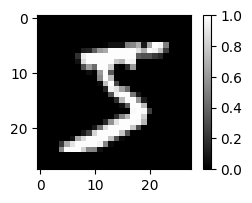

In [5]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [6]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)
val_dl = test_dl # alias val & test

## Make an (Regular) AE Model


First we'll try a regular autoencoder. Then we'll make it "variational"

In [7]:
latent_dim = 3   # more = better reconstructions, but 3 we can plot!

n_hid = [256, 64]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.

encoder = nn.Sequential(  
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim))

decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(),        # optional. we do want outputs on [0,1]
                )

use_conv=False

z =  tensor([[ 0.1119,  0.1603, -0.1139]], grad_fn=<AddmmBackward0>)
x.shape = (28, 28), min(x) = -0.2248477339744568, max(x) = 0.21424391865730286


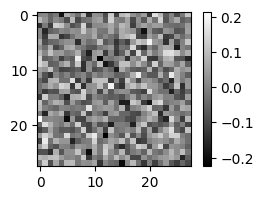

In [8]:
# test it, just to make sure we get no errors from mmult ops
x = x.view(x.size(0), -1)
z = encoder(x)
print("z = ",z)
x_hat = decoder(z)
x_hat = x_hat.view(x.size(0), 28, -1)
show_xs(x_hat)

^^ That was with randomly initialized weights, so we expect a random image. This was just to test that the matrix multiplications work out right.

In [9]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    def do_pred(self, batch, batch_idx):
        x, y = batch
        if not use_conv:
            x = x.view(x.size(0), -1)  # flatten for linear layer
        z, x_hat = self.forward(x)
        loss = nn.functional.mse_loss(x_hat, x) 
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

autoencoder = AEModel(encoder, decoder)
model = autoencoder  # alias

In [10]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='ae_tut')
try:
    wandb_logger.watch(model) 
except:
    pass

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [11]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)# , callbacks=RichProgressBar(leave=True))
trainer.fit(model=autoencoder, train_dataloaders=train_dl, val_dataloaders=val_dl )
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▅▆▄▃▄▃▃▂▃▃▂▂▂▁▂▃▂▂▁▂▂▃▂▂▂▃▂▂▂▁▂▂▂▃▁▂▁▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
train_loss,0.03167
trainer/global_step,9379
val_loss,0.032


z =  tensor([[ 0.1119,  0.1603, -0.1139]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.07947653532028198, max(x) = 1.0398459434509277


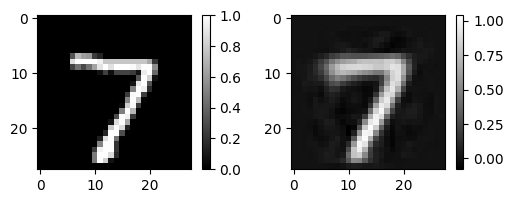

In [12]:
@torch.no_grad()
def test_inference(model, idx=None):
    model.eval()
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    if not use_conv:
        x = x.view(x.size(0), -1)
    x_hat = model.forward(x)
    x_hat = x_hat[-1]
    if not use_conv:
        x_hat = x_hat.view(x.size(0), -1)
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

idx = 0
test_inference(autoencoder, idx=idx)

## Now Let's Make it 'Varational'

To the  the reconstruction loss from before, we will add an extra (and somewhat *competing*) goal: to try to make the distribution of latent space approximately gaussian.  

Because of these two goals, the loss function will not be driven to zero, rather it will be driven to an "equilibrium" between these two different forces (one pulling toward better reconstruction loss, the other toward gaussian-ness.) 

In [13]:
# encoder now spits out mean and variance
vae_encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim*2)) # *2 b/c mu, log_var

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(), # optional forcing to [0,1]
                )

In [14]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, mu, log_var, z_hat, x_hat

    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, mu, log_var, z_hat, x_hat = self.forward(x)   
        
        recon_loss = nn.functional.mse_loss(x_hat, x)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 0.034/4.6 #0.001  # larger means blurrier/blobbier; rescale to get kl & recon similar
        rescaled_kl_loss = (kl_loss * scrunch_factor)
        loss = recon_loss + rescaled_kl_loss
        
        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(f'{log_prefix}kl_loss', kl_loss)
        self.log(F'{log_prefix}rescaled_kl_loss', rescaled_kl_loss)
        return loss 
        
    def training_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_epoch_start(self): # give us a new line for each epoch
        print('\n')

vae = VAEModel(vae_encoder, decoder)
model = vae

In [15]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vae_tut')
wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [16]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar())# leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ Sequential │  217 K │
│ 1 │ decoder │ Sequential │  218 K │
└───┴─────────┴────────────┴────────┘

Trainable params: 436 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 436 K                                                                                                
Total estimated model params size (MB): 1

Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/9  ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 534/938 0:00:03 • 0:00:03 153.07it/s v_num: sqqs train/loss: 0.057     
                                                                                 val/loss: 0.060                   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Epoch 4/9  ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 401/938 0:00:02 • 0:00:04 155.02it/s v_num: sqqs train/loss: 0.058     
                                                                                 val/loss: 0.058                   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 5/9  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 874/938 0:00:05 • 0:00:01 154.19it/s v_num: sqqs train/loss: 0.059     
                                                                                 val/loss: 0.058                   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/kl_loss,▁▃▄▅▆▅▆▆▆▆▇▆▆▇▆▆▆▇▇▇▆▇█▇▆▇▇▇▇▇█▇▇▇▇██▇▇▇
train/loss,█▆▅▂▄▄▆▃▄▃▅▄▅▄▃▅▂▂▂▂▃▃▂▂▁▄▃▂▃▂▂▁▂▃▂▄▃▃▂▃
train/recon_loss,█▆▅▃▃▄▄▃▃▃▃▃▄▃▂▄▂▂▂▁▂▂▁▂▁▃▂▁▂▂▁▁▂▂▂▂▂▂▂▂
train/rescaled_kl_loss,▁▃▄▅▆▅▆▆▆▆▇▆▆▇▆▆▆▇▇▇▆▇█▇▆▇▇▇▇▇█▇▇▇▇██▇▇▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/kl_loss,▁▂▄▅▇▆▆▆██
val/loss,█▄▃▂▂▂▂▁▁▁
val/recon_loss,█▆▅▃▂▂▃▂▁▁
val/rescaled_kl_loss,▁▂▄▅▇▆▆▆██
epoch,9


Doesn't seem like the loss is doing down as we train. Hmmm. Let's try some inference:

z =  tensor([[ 0.1119,  0.1603, -0.1139]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.036914847791194916, max(x) = 0.8603583574295044


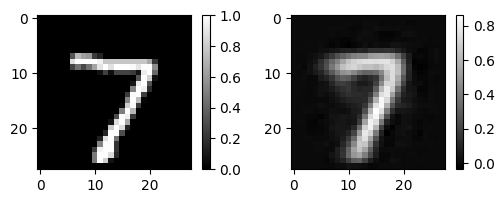

z =  tensor([[ 0.1119,  0.1603, -0.1139]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.025435514748096466, max(x) = 0.8184292912483215


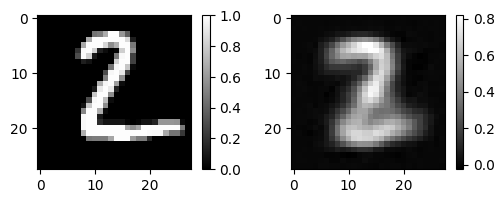

In [17]:
test_inference(vae, idx=0)
test_inference(vae, idx=1)

Looks similar to the regular autoencoder, right?

Now let's try perturbing our input a bit

## Comparing the AE and VAE

Perturbing the regular autoencoder with strength = 20.0:


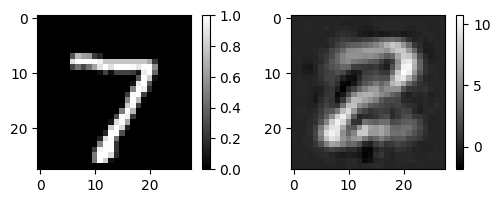

Perturbing the VAE with strength = 20.0:


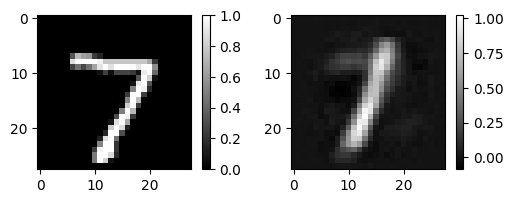

In [18]:
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    z = model.encoder(x.view(x.size(0), -1))
    if z.shape[-1] > latent_dim: z = z[:,:latent_dim] # if VAE, just use the mean values
    z_hat = z + strength*torch.randn_like(z)
    x_hat = model.decoder(z_hat)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat], show_stats=False)

idx=0
strength = 20.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable.

Note that without any final rescaling of outputs (e.g. via `nn.Sigmoid`), typically the output of the regular AE extends wayyy outside the [0,1] intensity bounds whereas the VAE's outputs are still properly bounded.


## Further Investigations: Add interpolation, 3D viz, more.

Make a grid of points in latent space and see what they decode to.

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([225, 1, 28, 28])
torch.Size([3, 452, 452])


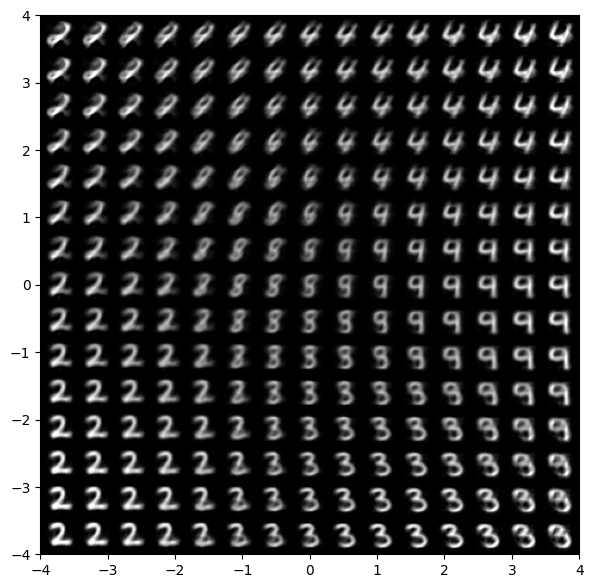

In [41]:
images = []
zcoord = 0.0
xmin, xmax, num = -4, 4, 15
with torch.no_grad():
    for xcoord in torch.linspace(xmin,xmax,num):
        for ycoord in torch.linspace(xmin,xmax,num):
            z_hat = torch.tensor([xcoord,ycoord,zcoord])#.to(device)
            #log_var = torch.zeros_like(mu).to(device)
            x_hat = decoder(z_hat)
            x_hat = x_hat.view(x.size(0), 28, -1)
            images.append(x_hat)

    im_t = torch.vstack(images).unsqueeze(1)
    print(im_t.shape) 

grid = torchvision.utils.make_grid(im_t, num)
print(grid.shape)
grid = rearrange(grid, 'c h w -> h w c') 


fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))


## Part 2: Adding Controls (Conditional Generation)


"Conditioning" means attaching controls to the model that, via training, it can learn to associate with specific kinds outputs. For example, we could do "class conditioning" where we tell it what class --- in our case, which digit -- we want the output to be.

The conditioning may take the form of adding or multiplying numbers to the activations, concatenating some controls,...lots of things. One general class of conditioning methods is often referred to as [FiLM layers](https://distill.pub/2018/feature-wise-transformations/), where FiLM stands for **F**eature-w**i**se **L**inear **M**odulation. Essentially it means we will apply our conditioning by both addition and multiplication.

How and where we apply the conditioning is up to us: we could apply it to the encoder, the latent space, and/or the decoder. We could include the conditioning signal in only one spot, or in between all layers. ...It kind of depends on what we want to do.  

Often for "Generative AI" systems, we leave the Encoder side alone, and apply the conditioning to the latent variable and the Decoder side. (Note also that any layer activation can be thought of a "latent variable", and some models don't necessarily restrict their attention to the "center of the hourglass" when it comes to talking about latents.)

> TODO: Draw a diagram!

Let's try a few different conditioning methods to see what we like best.

> FUN FACT: We've been using Mean Squared Error loss up to this point. I found (and you can try it too) that using MSE resulted in reliable conditioning, but *no variation* -- you'd get the exact same "8" or "6" (or whatever) every time. I noticed that most VAEs use Binary Cross Entropy loss, and when I switched the Conditional VAE loss below to BCE, I got variation! I'd like to better understand why MSE loss destroys the variation. Maybe I'll add an appendix.


In [34]:
# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta

We could do a conditional "regular autoencoder" but it would be kind of boring because whichever digit you ask for, say a 7, it'll just produce the exact same 7 every time.  We want some *variation* to the outputs, so let's make a conditional VAE

**"conditioning strength":**
Maybe this is just me, but I like the idea of having a "conditioning strength" parameter, so that we can tell the model whether we want no conditioning or full conditioning, or somewhere in between.

I haven't seen this done elsewhere...but I just like the idea, so here goes!

In [35]:
# Conditional VAE

latent_dim = 4  

n_hid = [256, 64]  # could imagine adding more layers

act = nn.GELU # this is popular in many models

# should we condition the encoder too?
# doing so may help give structure to the latent space
vae_encoder = nn.Sequential(    # same as before
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], 2*latent_dim),
                )

cond_dim = 10  # we'll use one-hot encoding for class conditioning; 10 classes


class EncoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.l1 = nn.Linear(28*28, n_hid[0])
        self.f1 = FiLM(n_hid[0], cond_dim)
        self.l2 = nn.Linear(n_hid[0], n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l3 = nn.Linear(n_hid[1], 2*latent_dim)
        self.act = act()
    def forward(self, x, cond, debug=False):
        x = self.act( self.l1(x) )
        x = self.f1(x,cond)
        x = self.act( self.l2(x) )
        #x = self.f2(x, cond)
        x = self.l3(x)
        if debug: print("leaving Encoder, x.shape =",x.shape)
        return x

# Let's try sticking a FiLM before each Linear layer in the Decoder.
# Oh, for the decoder we can't just use nn.Sequential anymore...
class DecoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        #self.f1 = FiLM(latent_dim, cond_dim)
        self.l1 = nn.Linear(latent_dim, n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l2 = nn.Linear(n_hid[1], n_hid[0])
        #self.f3 = FiLM(n_hid[0], cond_dim)
        self.l3 = nn.Linear(n_hid[0], 28 * 28)
        self.act = act()

    def forward(self, x, cond, debug=False):
        if debug: print("Debug: 1 x.shape =",x.shape)
        #x = self.f1(x, cond)
        x = self.act( self.l1(x) )
        x = self.f2(x, cond)
        x = self.act( self.l2( x ) )
        #x = self.f3(x, cond)
        x = self.l3( x )
        x = torch.sigmoid(x) # needed if you want to use BCE loss
        
        return x
        
vae_encoder_cond = EncoderCond(latent_dim, n_hid, cond_dim)
vae_decoder_cond = DecoderCond(latent_dim, n_hid, cond_dim)


In [36]:
# instead of nn.Module, we use L.LightningModule
class CondVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = vae_encoder_cond
        self.decoder = vae_decoder_cond
        self.ema_loss = 0.06

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x, cond):
        z = self.encoder(x, cond)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return z, mu, log_var, z_hat, x_hat

    def gen(self, y, n_gen=1):
        mu = 4*torch.randn((n_gen, latent_dim))
        log_var = 2*torch.randn((n_gen, latent_dim))
        z_hat = self.reparam_sample(mu, log_var)
        cond = F.one_hot(torch.tensor(y), num_classes=10).float()
        x_hat = self.decoder(z_hat, cond)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        cond = F.one_hot(y, num_classes=10).float().to(x.device) # pass in the desired output class as cond

        x_targ, cond_targ = x, cond  # ordinary cond-vae 
        # if False: # add mixup
        #     print("Warning, running with mixup!!!") 
        #     cond_strength = torch.rand((1)).to(x.device)
        #     # draw x2, y2 values from elsewhere in the batch
        #     rand_inds = torch.randperm(x.size()[0])
        #     x2, y2 = x[rand_inds], y[rand_inds]
        #     x2 = x2.view(x.size(0), -1)
        #     cond2 = F.one_hot(y2, num_classes=10).float().to(x.device)
        #     # target is between x and x2, determined by cond_strength
        #     x_targ    = torch.lerp(x,    x2,    cond_strength)
        #     cond_targ = torch.lerp(cond, cond2, cond_strength)

        z, mu, log_var, z_hat, x_hat = self.forward(x, cond_targ)

        #recon_loss = nn.functional.mse_loss(x_hat, x_targ)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x_targ)
        
        scrunch_factor = 0.1
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * scrunch_factor)
        with torch.no_grad():
            self.ema_loss = 0.99*self.ema_loss + 0.01*loss.detach().item()
            self.log('ema_loss', self.ema_loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [37]:
cond_vae = CondVAEModel(encoder, decoder)

epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=cond_vae, train_dataloaders=train_dl)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shawley/envs/dlaie/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's take a look at inference:

       Source,                Destination,              Expected,                Output
y_targ =  4
cond_targ = tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
z =  tensor([[ 0.1119,  0.1603, -0.1139]], grad_fn=<AddmmBackward0>)


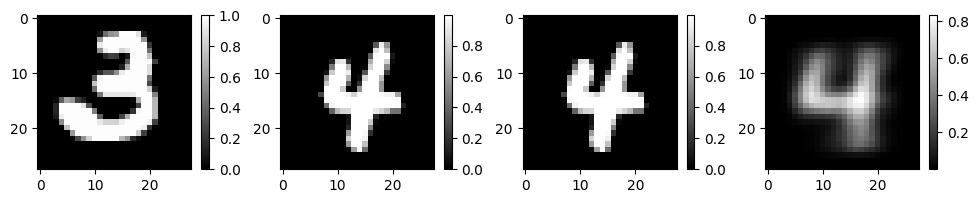

In [38]:
@torch.no_grad()
def test_cond_inference(model, cond_strength=1.0, idx=None):
    "Try to map from one digit to another digit"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x2, y2 = test_ds[idx+1]
    x_targ = torch.lerp(x, x2, cond_strength) # picture of what we might expect
    y_targ = y2
    print("y_targ = ",y_targ)
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()  # but now we go all the way
    cond2 = F.one_hot(torch.tensor(y2), num_classes=10).float()
    cond_targ = torch.lerp( cond, cond2, cond_strength)
    print("cond_targ =",cond_targ)
    x_hat = model.forward(x.view(x.size(0), -1), cond_targ)[-1]
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x2,x_targ,x_hat], show_stats=False)


idx = torch.randint( len(test_ds)-1, (1,))[0]
print("       Source,                Destination,              Expected,                Output")
test_cond_inference(cond_vae, cond_strength=1.0, idx=idx )


x.shape = (28, 28), min(x) = 6.10894460351119e-07, max(x) = 0.9118581414222717


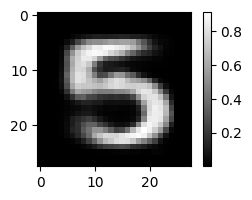

x.shape = (28, 28), min(x) = 9.195629786518111e-07, max(x) = 0.9130609631538391


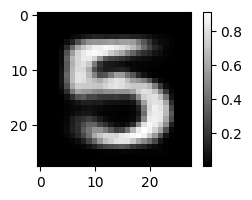

x.shape = (28, 28), min(x) = 3.3439496291975956e-06, max(x) = 0.7015662789344788


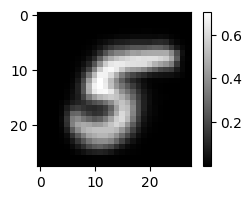

In [39]:
@torch.no_grad()
def test_cond_gen(model, y_targ, idx=None):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x_hat = model.gen(y_targ)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x_hat])

y_targ=5
test_cond_gen(cond_vae, y_targ, idx=idx)
test_cond_gen(cond_vae, y_targ, idx=idx)
test_cond_gen(cond_vae, y_targ, idx=idx)

> For "fun": re-instantiate the model only use `mse_loss` instead of `binary_cross_entropy`. You'll see the same "5" every time above, and a grid of the same "8"s below:

grid.shape = torch.Size([3, 452, 452])


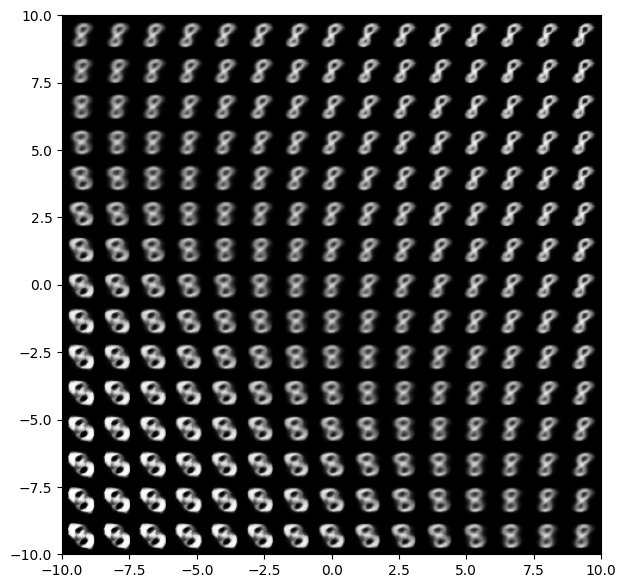

grid.shape = torch.Size([3, 452, 452])


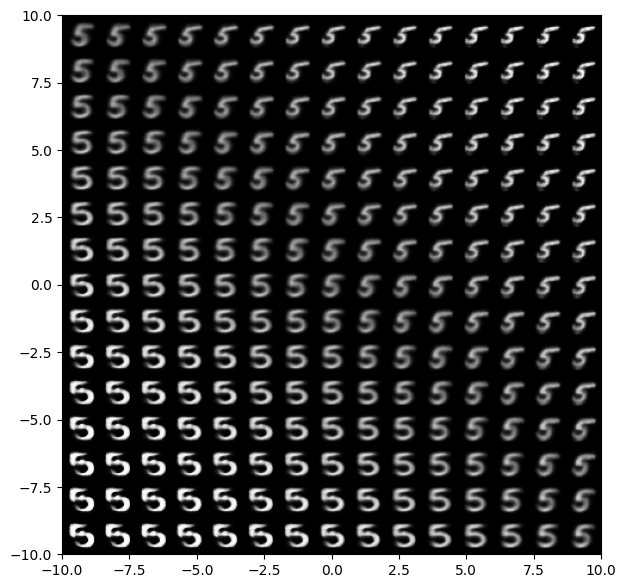

In [40]:
def cond_grid(y):
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()
    nrow = 15
    xmin, xmax = -10,10
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0,0.0])#.to(device)
                zhats.append(z_hat)
                
        z_hat_batch = torch.vstack(zhats).unsqueeze(1) # unsqueeze adds dummy color channel
        x_hat = vae_decoder_cond(z_hat_batch, cond)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)
    
    grid = torchvision.utils.make_grid(x_hat, nrow)
    print("grid.shape =",grid.shape)
    
    grid = rearrange(grid, 'c h w -> h w c') 
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

cond_grid(8)
cond_grid(5)

## Going Further: VQ-VAE

"Vector Quantization"